In [7]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

In [3]:
df = pl.read_csv("penguins_size.csv")

In [4]:
df = df.drop_nans().drop_nulls()

In [5]:
df

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,f64,f64,i64,i64,str
"""Adelie""","""Torgersen""",39.1,18.7,181,3750,"""MALE"""
"""Adelie""","""Torgersen""",39.5,17.4,186,3800,"""FEMALE"""
"""Adelie""","""Torgersen""",40.3,18.0,195,3250,"""FEMALE"""
"""Adelie""","""Torgersen""",36.7,19.3,193,3450,"""FEMALE"""
"""Adelie""","""Torgersen""",39.3,20.6,190,3650,"""MALE"""
…,…,…,…,…,…,…
"""Gentoo""","""Biscoe""",47.2,13.7,214,4925,"""FEMALE"""
"""Gentoo""","""Biscoe""",46.8,14.3,215,4850,"""FEMALE"""
"""Gentoo""","""Biscoe""",50.4,15.7,222,5750,"""MALE"""


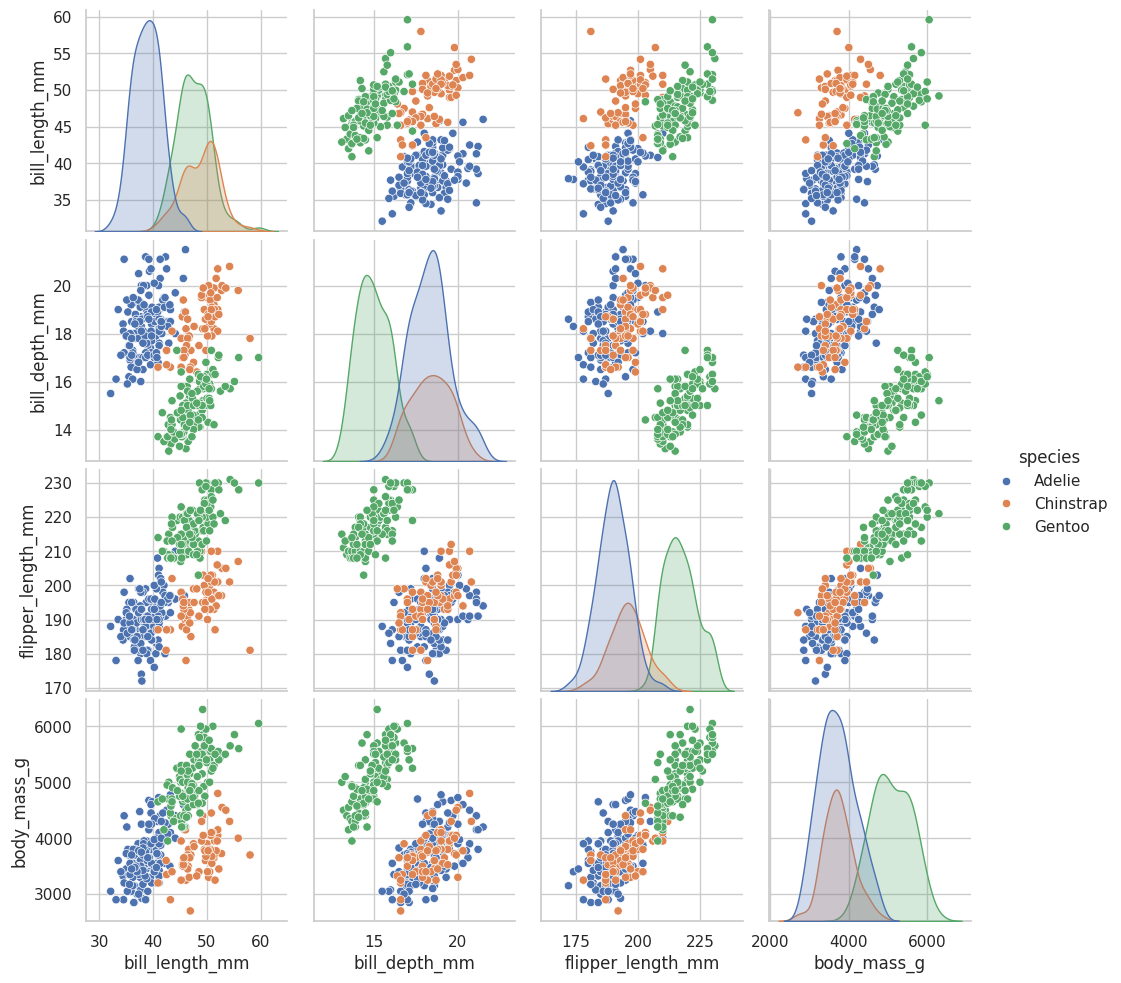

In [13]:
df_pandas = df.to_pandas()

# Create a pairplot with legend
sns.pairplot(df.to_pandas(), hue='species')

plt.show()

Na podstawie powyższego wykresu wybieram:

- bill_depth_mm i body_mass_g dla Gentoo i Chinstrap jako liniowo separowalne
- bill_length_mm i flipper_length_mm dla Chinstrap i Gentoo jako nieliniowo separowalne

Dokładność modelu: 1.00


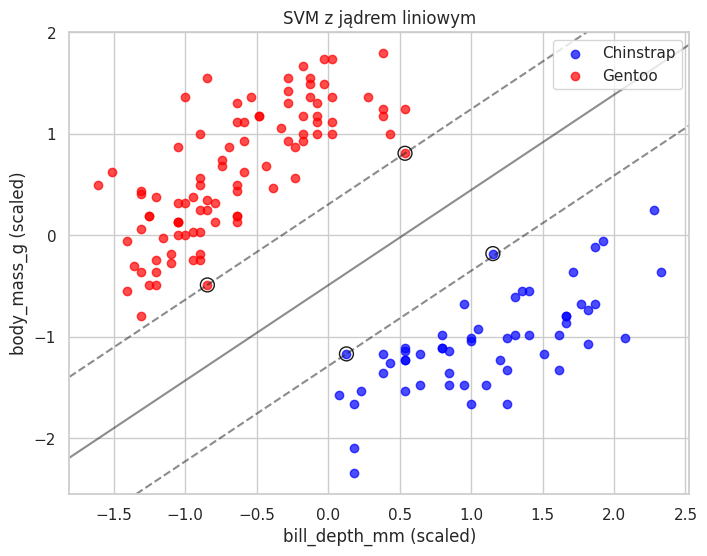

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

import matplotlib.pyplot as plt

# Wybór tylko dwóch gatunków
df_binary = df_pandas[df_pandas['species'].isin(['Gentoo', 'Chinstrap'])]

# Wybór cech i zmiennej docelowej
X = df_binary[['bill_depth_mm', 'body_mass_g']].values
y = df_binary['species'].map({'Gentoo': 1, 'Chinstrap': 0}).values

# Podział na zbiór treningowy i walidacyjny (80%-20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Autoskalowanie danych
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Budowa modelu SVM z jądrem liniowym
model = SVC(kernel='linear')
model.fit(X_train_scaled, y_train)

# Przewidywanie na zbiorze walidacyjnym
y_pred = model.predict(X_val_scaled)

# Obliczanie dokładności
accuracy = accuracy_score(y_val, y_pred)
print(f'Dokładność modelu: {accuracy:.2f}')

# Wykres z wektorami własnymi i marginesem
plt.figure(figsize=(8,6))
chinstrap_idx = (y_train == 0)
gentoo_idx = (y_train == 1)

plt.scatter(X_train_scaled[chinstrap_idx, 0], X_train_scaled[chinstrap_idx, 1],
            color='blue', alpha=0.7, label='Chinstrap')
plt.scatter(X_train_scaled[gentoo_idx, 0], X_train_scaled[gentoo_idx, 1],
            color='red', alpha=0.7, label='Gentoo')
plt.legend()
# Obliczenie marginesów
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Stworzenie siatki aby narysować płaszczyznę decyzji
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 30),
                     np.linspace(ylim[0], ylim[1], 30))
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Narysowanie płaszczyzny decyzyjnej i marginesów
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])

# Zaznaczenie wektorów wspierających
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], 
            s=100, linewidth=1, facecolors='none', edgecolors='k')

plt.xlabel('bill_depth_mm (scaled)')
plt.ylabel('body_mass_g (scaled)')
plt.title('SVM z jądrem liniowym')
plt.show()

Dla danych tego typu, które da się łatwo podzielić liniowo dokładność równa 1.0 nie jest zaskoczeniem. Model dobrze sobie poradził

Dokładność modelu z jądrem linear: 0.97
Dokładność modelu z jądrem poly: 0.95
Dokładność modelu z jądrem rbf: 0.97


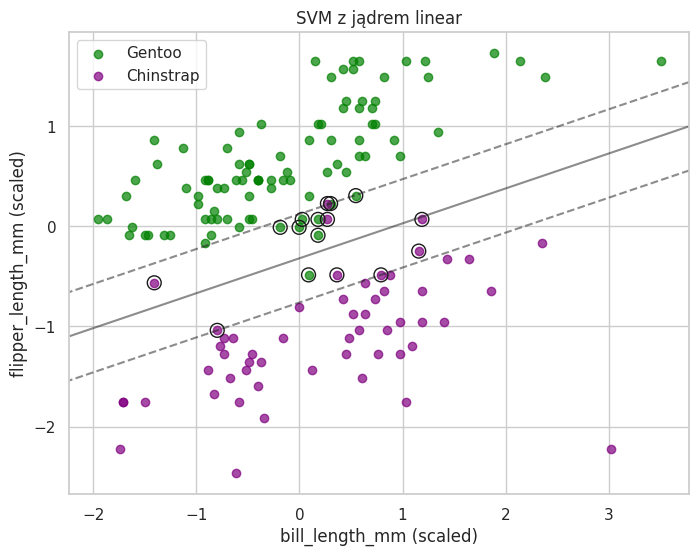

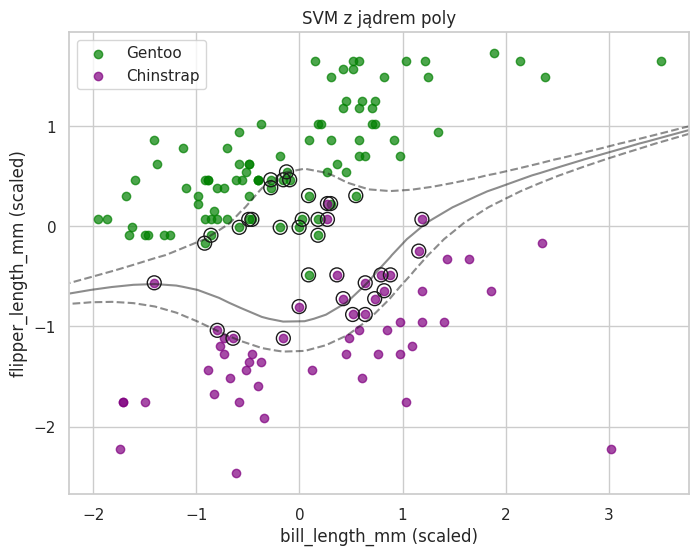

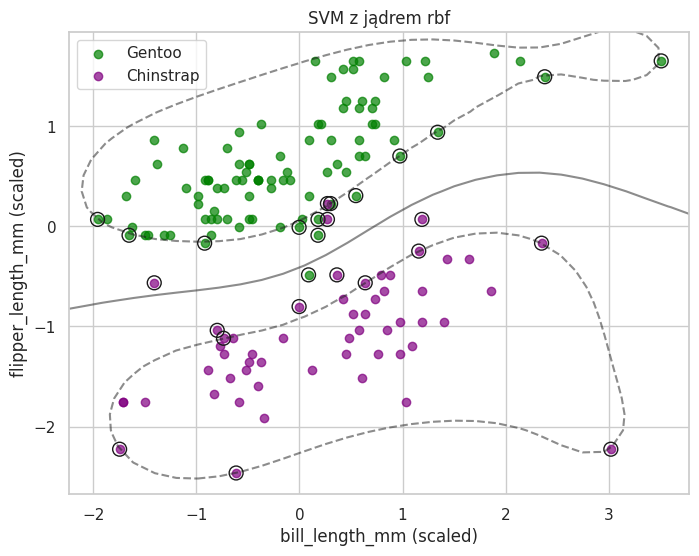

In [19]:
# Wybór tylko dwóch gatunków: Gentoo i Chinstrap
df_nl = df_pandas[df_pandas['species'].isin(['Gentoo', 'Chinstrap'])]

# Wybór cech i zmiennej docelowej
X_nl = df_nl[['bill_length_mm', 'flipper_length_mm']].values
y_nl = df_nl['species'].map({'Gentoo': 0, 'Chinstrap': 1}).values

# Podział na zbiór treningowy i walidacyjny (80%-20%)
X_train_nl, X_val_nl, y_train_nl, y_val_nl = train_test_split(X_nl, y_nl, test_size=0.2, random_state=42)

# Autoskalowanie danych
scaler_nl = StandardScaler()
X_train_scaled_nl = scaler_nl.fit_transform(X_train_nl)
X_val_scaled_nl = scaler_nl.transform(X_val_nl)

# Definicja modeli z różnymi funkcjami jądra
kernels = ['linear', 'poly', 'rbf']
models_nl = {}
accuracies_nl = {}

for kernel in kernels:
    svm_model_nl = SVC(kernel=kernel)
    svm_model_nl.fit(X_train_scaled_nl, y_train_nl)
    y_pred_nl = svm_model_nl.predict(X_val_scaled_nl)
    accuracy_nl = accuracy_score(y_val_nl, y_pred_nl)
    models_nl[kernel] = svm_model_nl
    accuracies_nl[kernel] = accuracy_nl
    print(f'Dokładność modelu z jądrem {kernel}: {accuracy_nl:.2f}')

for kernel in kernels:
    model = models_nl[kernel]
    
    plt.figure(figsize=(8,6))
    adelie_idx = (y_train_nl == 0)
    chinstrap_idx = (y_train_nl == 1)
    
    plt.scatter(X_train_scaled_nl[adelie_idx, 0], X_train_scaled_nl[adelie_idx, 1],
                color='green', alpha=0.7, label='Gentoo')
    plt.scatter(X_train_scaled_nl[chinstrap_idx, 0], X_train_scaled_nl[chinstrap_idx, 1],
                color='purple', alpha=0.7, label='Chinstrap')
    plt.legend()
    
    # Compute margins
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Create grid to plot decision boundary
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 30),
                         np.linspace(ylim[0], ylim[1], 30))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary and margins
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    
    # Plot support vectors
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], 
                s=100, linewidth=1, facecolors='none', edgecolors='k')
    
    plt.xlabel('bill_length_mm (scaled)')
    plt.ylabel('flipper_length_mm (scaled)')
    plt.title(f'SVM z jądrem {kernel}')
    plt.show()

Dla danych, które nie dzielą się ładnie liniowo użycie nieliniowego kernela powinno dać najlepsze wyniki. W tym przypadku jednak linear poradziło sobie tak samo dobrze jak nieliniowy rbf (0.97). Najgorzej poradziło sobie poly (0.95).

Tutaj różnice są niewielkie. Jednakże w innym przypadku nieliniowy kernel powinien poradzić sobie lepiej.